In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


In [2]:
# Adjust these for your local paths!
img_dir = "../Firefighting-Device-Detection-6/train"
annot_path = os.path.join(img_dir, "_annotations.coco.json")

# This is the size to which we will resize each symbol patch
image_size = 32

# Initialize COCO
coco = COCO(annot_path)
image_ids = coco.getImgIds()
print("Total images found in COCO:", len(image_ids))


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Total images found in COCO: 102


Total symbol patches extracted: 2606


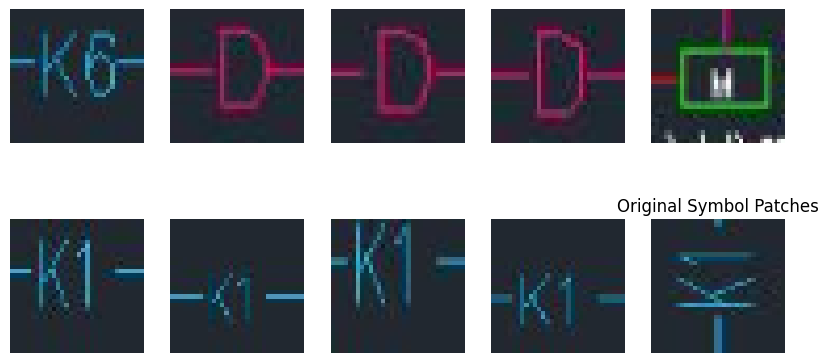

In [4]:
def load_symbol_patches():
    symbol_patches = []
    for img_id in image_ids:
        # get image path
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info['file_name'])
        
        # read and convert color
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # find annotations
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        for ann in anns:
            x, y, w, h = map(int, ann['bbox'])
            patch = img[y:y+h, x:x+w]
            patch = cv2.resize(patch, (image_size, image_size))
            patch = patch / 255.0
            symbol_patches.append(patch)
    return symbol_patches

symbol_patches = load_symbol_patches()
print(f"Total symbol patches extracted: {len(symbol_patches)}")

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(symbol_patches[i])
    plt.axis('off')
plt.title("Original Symbol Patches")
plt.show()


In [7]:
def augment_image(image):
    """Given a single [H,W,3] image in [0,1], apply random augmentations."""
    x = tf.convert_to_tensor(image, dtype=tf.float32)
    # Example set of augmentations:
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta=0.2)
    x = tf.image.random_contrast(x, 0.8, 1.2)
    # Optionally, random crop with padding:
    # x = tf.image.resize_with_crop_or_pad(x, image_size + 4, image_size + 4)
    # x = tf.image.random_crop(x, (image_size, image_size, 3))
    return x

def generate_augmented_pairs(patches):
    """Return two numpy arrays of shape [N, H, W, 3], each a random augmentation of the same patch."""
    pairs_1, pairs_2 = [], []
    for patch in patches:
        aug1 = augment_image(patch)
        aug2 = augment_image(patch)
        pairs_1.append(aug1.numpy())
        pairs_2.append(aug2.numpy())
    return np.array(pairs_1), np.array(pairs_2)

pairs_1, pairs_2 = generate_augmented_pairs(symbol_patches)
print("Generated augmented pairs:", pairs_1.shape, pairs_2.shape)


Generated augmented pairs: (2606, 32, 32, 3) (2606, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


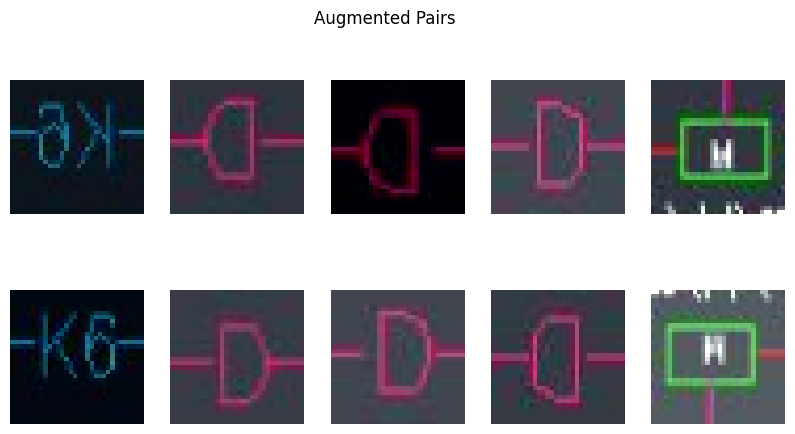

In [8]:
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(pairs_1[i])
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(pairs_2[i])
    plt.axis('off')
plt.suptitle("Augmented Pairs")
plt.show()


In [9]:
from updated_code.model import SimCLR

input_shape = (32, 32, 3)
simclr_model = SimCLR(projection_dim=128, input_shape=input_shape)

# Build the model by running a dummy batch
dummy_input = tf.random.uniform([1, *input_shape])
_ = simclr_model(dummy_input)  # triggers build
simclr_model.summary()


Model: "sim_clr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ res_net (ResNet)                │ ?                      │    33,620,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projection_head                 │ ?                      │     1,114,752 │
│ (ProjectionHead)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,735,680 (132.51 MB)

 Trainable params: 34,682,560 (132.30 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    """NT-Xent:  Intra-batch negative, positive is diagonal."""
    z_i = tf.math.l2_normalize(z_i, axis=1)
    z_j = tf.math.l2_normalize(z_j, axis=1)

    logits = tf.matmul(z_i, z_j, transpose_b=True)  # [batch, batch]
    logits /= temperature

    # positives are diagonal
    batch_size = tf.shape(z_i)[0]
    labels = tf.range(batch_size)

    # cross-entropy in both directions
    loss_i = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels, logits
    )
    loss_j = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels, tf.transpose(logits)
    )
    return tf.reduce_mean(loss_i + loss_j)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(x1, x2):
    with tf.GradientTape() as tape:
        z1 = simclr_model(x1, training=True)
        z2 = simclr_model(x2, training=True)
        loss = nt_xent_loss(z1, z2, temperature=0.5)
    grads = tape.gradient(loss, simclr_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, simclr_model.trainable_variables))
    return loss


In [11]:
pairs_1, pairs_2 = generate_augmented_pairs(symbol_patches)

# Suppose we do a simple dataset with from_tensor_slices
BATCH_SIZE = 128
EPOCHS = 5

train_ds = tf.data.Dataset.from_tensor_slices((pairs_1, pairs_2))
train_ds = train_ds.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Epoch 1, Loss: 7.9203
Epoch 2, Loss: 7.1266
Epoch 3, Loss: 6.8460
Epoch 4, Loss: 6.5925
Epoch 5, Loss: 6.4557


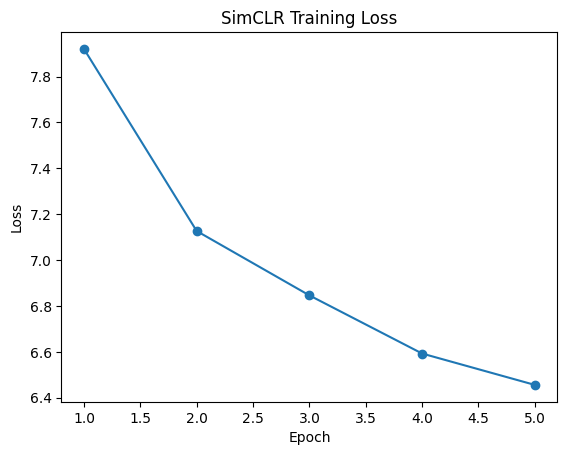

In [12]:
loss_history = []

for epoch in range(EPOCHS):
    total_loss = 0.0
    num_batches = 0
    for (p1, p2) in train_ds:
        loss_val = train_step(p1, p2)
        total_loss += loss_val.numpy()
        num_batches += 1
    avg_loss = total_loss / num_batches
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

plt.plot(range(1, EPOCHS+1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SimCLR Training Loss")
plt.show()


In [15]:
# Get category IDs and their names
cat_ids = coco.getCatIds()
categories = coco.loadCats(cat_ids)
symbol_type_names = [cat['name'] for cat in categories]
print("Symbol Types:", symbol_type_names)


Symbol Types: ['firefighting-deveces', '24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-water-pump-manual-control-line', 'gas-spray-audible-and-visual-alarm', 'gun-type-infrared-camera-in-the-basement', 'i-o-module', 'input-module', 'light-display', 'manual-alarm-button-with-fire-telephone-jack', 'manual-automatic-switching-device', 'metal-modular-box', 'normally-open-smoke-exhaust-valve-with-280-operation', 'normally-open-smoke-exhaust-valve-with-70-operation'

In [16]:
symbol_type_example_patches = {}  # Will map {symbol_type: example_patch}

# Iterate through all images and extract one example per symbol type
for img_id in image_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    
    # Read and convert the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    
    for ann in anns:
        # Get the symbol type for this annotation
        cat_id = ann['category_id']
        symbol_type = coco.loadCats(cat_id)[0]['name']
        
        # If we haven't saved an example for this symbol type, do it now
        if symbol_type not in symbol_type_example_patches:
            x, y, w, h = map(int, ann['bbox'])
            patch = img[y:y+h, x:x+w]
            patch = cv2.resize(patch, (image_size, image_size))
            patch = patch / 255.0  # Normalize to [0, 1]
            
            # Save the patch
            symbol_type_example_patches[symbol_type] = patch

    # Stop early if all symbol types have been sampled
    if len(symbol_type_example_patches) == len(symbol_type_names):
        break

print(f"Extracted {len(symbol_type_example_patches)} patches.")


Extracted 40 patches.


In [17]:
symbol_type_names = list(symbol_type_example_patches.keys())
symbol_type_example_patches = list(symbol_type_example_patches.values())
print("Symbol types:", symbol_type_names)
print("Number of example patches:", len(symbol_type_example_patches))


Symbol types: ['pressure-switch-flow-switch-start-pump-line', '24V-power-cord', 'metal-modular-box', 'fire-fan-manual-control-line', 'i-o-module', 'input-module', 'water-flow-indicator', 'safety-signal-valve', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'manual-automatic-switching-device', 'normally-open-smoke-exhaust-valve-with-280-operation', 'gun-type-infrared-camera-in-the-basement', 'security-video-intercom-door-machine', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'video-intercom-card-reader', 'smoke-vent', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'fire-hydrant-button', 'manual-alarm-button-with-fire-telephone-jack', 'secondary-fire-shutter-door-control-box', 'acousto-optic-alarm', 'area-display', 'normally-open-smoke-exhaust-valve-with-70-operation', 'speaker', 'fire-broadcasting-line', 'light-display', 'fire-telephone-extension', 'gas-spray-audible-and-visual-alarm', 'deflation-indicator-light', 'the-electromagnetic

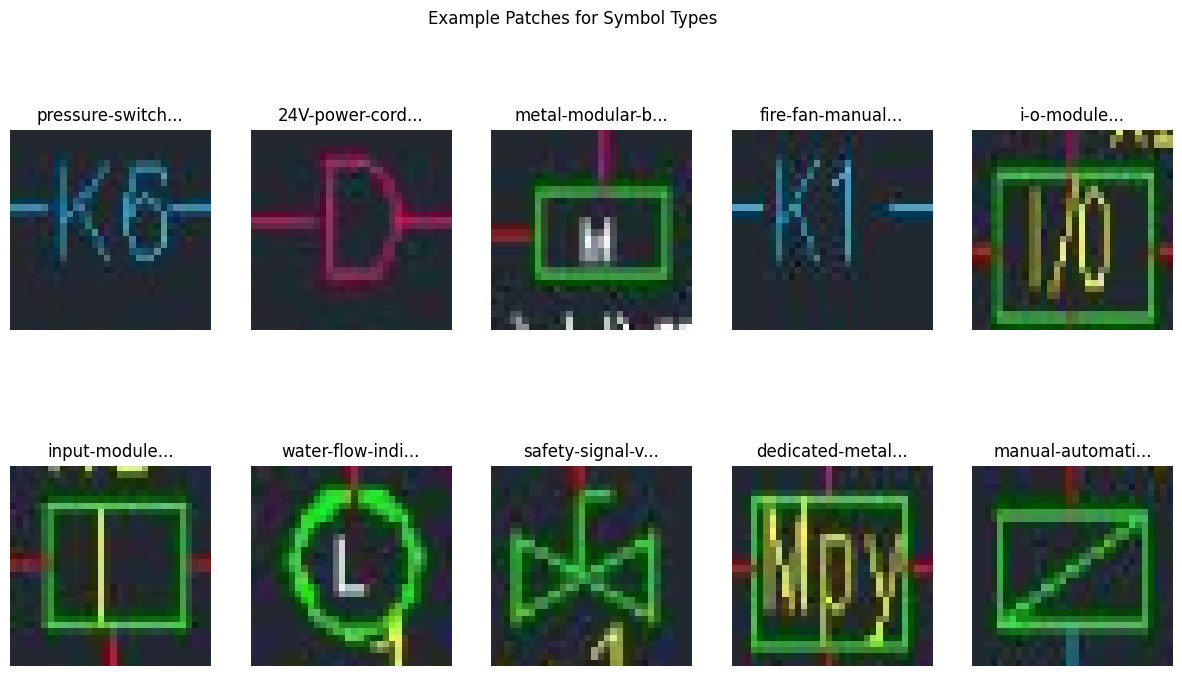

In [18]:
plt.figure(figsize=(15, 8))
for i in range(min(10, len(symbol_type_example_patches))):
    plt.subplot(2, 5, i+1)
    plt.imshow(symbol_type_example_patches[i])
    plt.title(symbol_type_names[i][:15] + '...')  # Truncate long names
    plt.axis('off')
plt.suptitle("Example Patches for Symbol Types")
plt.show()


In [19]:
# Normalize and pass example patches through the encoder
prototypes = []
for patch in symbol_type_example_patches:
    patch_tensor = tf.expand_dims(patch, 0)  # Add batch dimension
    emb = simclr_model.encoder(patch_tensor, training=False)  # Get embedding
    emb = tf.math.l2_normalize(emb, axis=1)  # Normalize
    prototypes.append(emb)

prototypes = tf.concat(prototypes, axis=0)  # shape [num_symbols, embedding_dim]


In [22]:
def predict_symbol_type(new_patch):
    new_patch_tensor = tf.expand_dims(new_patch, 0)
    new_emb = simclr_model.encoder(new_patch_tensor, training=False)
    new_emb = tf.math.l2_normalize(new_emb, axis=1)
    
    # Compute cosine similarity
    similarities = tf.matmul(new_emb, prototypes, transpose_b=True)  # shape [1, num_symbols]
    predicted_index = tf.argmax(similarities, axis=1).numpy().item()  # Correct extraction
    
    return symbol_type_names[predicted_index], similarities.numpy()

# Test the prediction with a random patch
test_patch = symbol_patches[0]  # Use any random symbol patch
predicted_label, scores = predict_symbol_type(test_patch)
print("Predicted Symbol Type:", predicted_label)
print("Similarity Scores:", scores)


Predicted Symbol Type: pressure-switch-flow-switch-start-pump-line
Similarity Scores: [[1.         0.4379893  0.5149108  0.90850973 0.22197545 0.29299825
  0.18666986 0.14549159 0.18565609 0.17703587 0.6478574  0.23266774
  0.23565182 0.18615866 0.21086529 0.14717136 0.22090125 0.189488
  0.16181831 0.15613559 0.14250186 0.18126461 0.1462147  0.45701718
  0.6776489  0.15284687 0.3852942  0.30188876 0.14656001 0.43865252
  0.43939513 0.54446006 0.50366825 0.44165963 0.7091541  0.18287627
  0.5307368  0.45265332 0.9643869  0.3859356 ]]


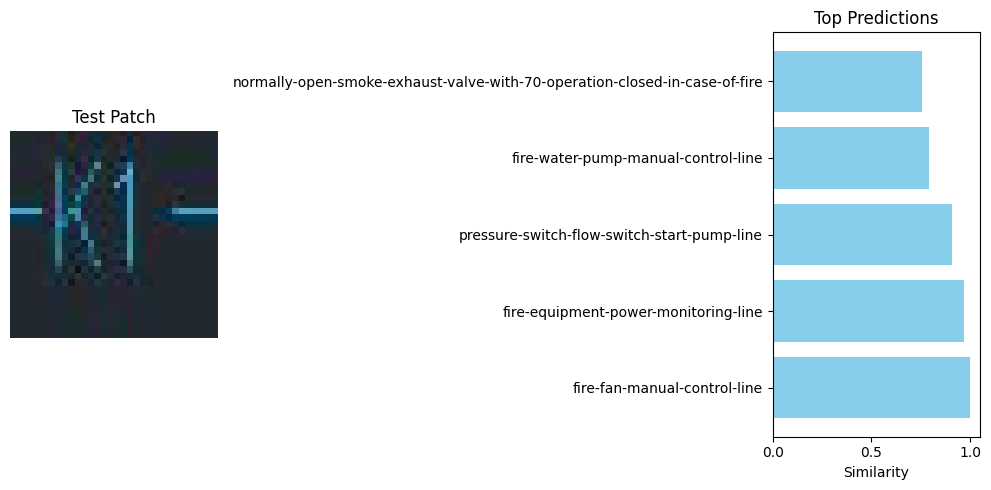

Predicted Symbol Type: fire-fan-manual-control-line
Similarity Scores: [[0.90850973 0.39654654 0.48026145 1.         0.1942858  0.34735632
  0.17943351 0.136929   0.18309176 0.2525472  0.5782894  0.25375247
  0.22634216 0.17998874 0.34057975 0.16035052 0.19893374 0.2870791
  0.21882892 0.19926824 0.15491378 0.17545217 0.14701465 0.48316443
  0.61394316 0.16693243 0.52322125 0.30753195 0.17234673 0.65162194
  0.5933594  0.67314065 0.66621447 0.6428227  0.753986   0.18117395
  0.79186064 0.6983653  0.9708712  0.4886482 ]]


In [23]:
import matplotlib.pyplot as plt

def visualize_prediction(test_patch):
    # Predict the symbol type
    predicted_label, scores = predict_symbol_type(test_patch)

    # Plot the test patch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_patch)
    plt.title("Test Patch")
    plt.axis('off')

    # Plot similarity scores
    top_k = 5  # Show top-5 scores
    top_indices = np.argsort(-scores[0])[:top_k]
    top_labels = [symbol_type_names[i] for i in top_indices]
    top_scores = [scores[0][i] for i in top_indices]

    plt.subplot(1, 2, 2)
    plt.barh(top_labels, top_scores, color='skyblue')
    plt.xlabel("Similarity")
    plt.title("Top Predictions")

    plt.tight_layout()
    plt.show()

    print(f"Predicted Symbol Type: {predicted_label}")
    print(f"Similarity Scores: {scores}")

# Test with a random patch
random_patch = symbol_patches[5]  # Pick any random patch
visualize_prediction(random_patch)
